In [4]:
import numpy as np
import pandas as pd
import h5py
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io


In [17]:
h5f = h5py.File('ckp/images_30k.h5', 'r')
train_embeddings = h5f['image_embeddings'][:]

In [18]:
# load images_resized_sorted:
images = pd.read_csv('index/images_resized_30k.csv')

links = pd.read_csv('inditextech_hackupc_challenge_images.csv')

In [19]:
def get_image(image_name):
    row, col = image_name.split('_')[0:2]

    image_url = links.iloc[int(row), int(col)]
    
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            # image = Image.open(io.BytesIO(response.content))
            import matplotlib.pyplot as plt
            # Convert response.content to image
            image = Image.open(io.BytesIO(response.content))

            return image

        else:
            print(f"Failed to download: {image_name}")
            get_image(image_name)  # Retry download
    
    except Exception as e:
        print(f"Error downloading {image_name}: {str(e)}")


In [60]:
def get_nearest_products(path, num_options=3):
    
    path_index = images[images['path'] == path].index[0]

    product_row = images[images['path'] == path]['row'].values[0]
    
    new_embedding = train_embeddings[path_index]
    k = 3 * num_options + 1

    similarities = np.array([cosine(new_embedding, emb) for emb in train_embeddings])
    
    k_lowest_values_indices = np.argsort(similarities)
    
    k_lowest_values = similarities[k_lowest_values_indices]
    print(k_lowest_values)
    
    viewed_rows = []
    nearest_images = []

    i=0
    while len(nearest_images) < num_options:
        idx = k_lowest_values_indices[i]
        if images.loc[idx, 'row'] in viewed_rows + [product_row]:
            i+=1
            continue
        else:
        #check if the image distance with some image in the nearist_images is very close to 0
            if any([np.isclose(cosine(train_embeddings[images[images['path'] == image].index[0]], train_embeddings[idx]), 0, atol=1e-3) for image in nearest_images]):
                i+=1
                continue
        nearest_images.append(images.loc[idx, 'path'])
        viewed_rows.append(images.loc[idx, 'row'])
        i+=1
  
    return nearest_images

[0.         0.01295728 0.0138659  ... 0.59520476 0.62623478 0.67543265]


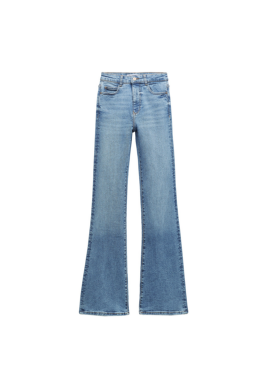

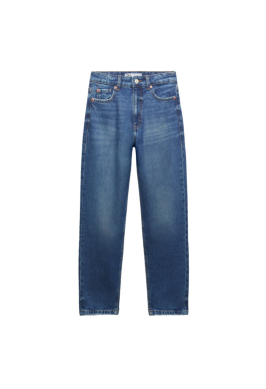

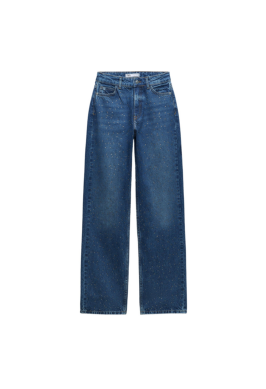

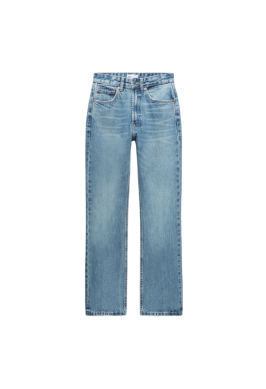

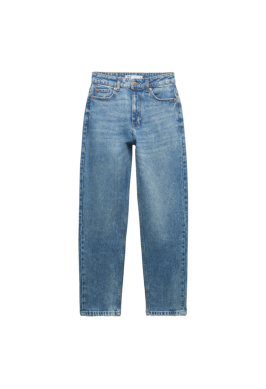

In [74]:
def get_images_from_product(product):
    for path in [product] + get_nearest_products(product, 4):
            plt.imshow(get_image(path))
            plt.axis('off')
            plt.show()

In [71]:
def show_product_neighbours(product):
    product_paths = [product] + get_nearest_products(product, 3)

    fig, axes = plt.subplots(1, len(product_paths), figsize=(15, 5))

    for i, path in enumerate(product_paths):
        axes[i].imshow(get_image(path))
        axes[i].axis('off')

    plt.show()

[0.         0.01295728 0.0138659  ... 0.59520476 0.62623478 0.67543265]


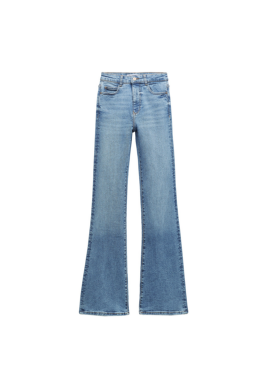

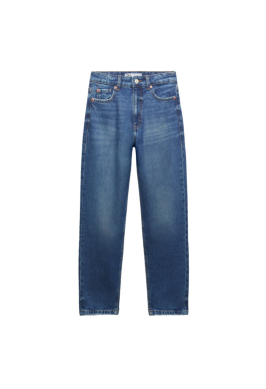

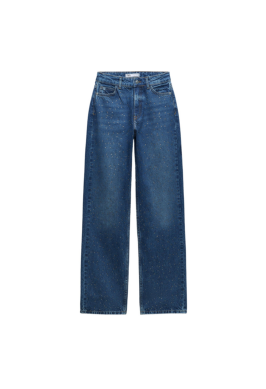

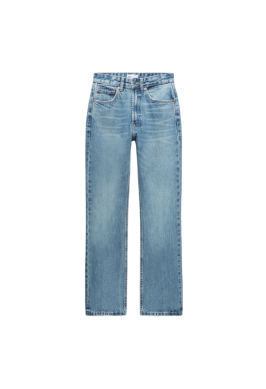

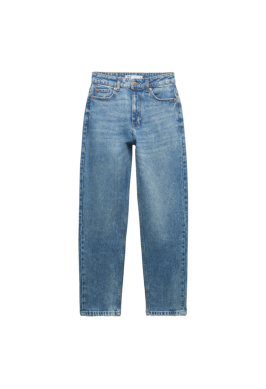

In [72]:
show_product_neighbours('34137_2_2023_I_0_1')

[2.15023790e-08 2.15023790e-08 4.75043045e-02 ... 5.77571607e-01
 5.91865644e-01 6.27121846e-01]


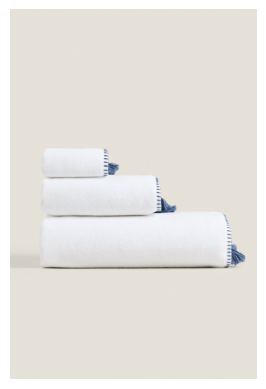

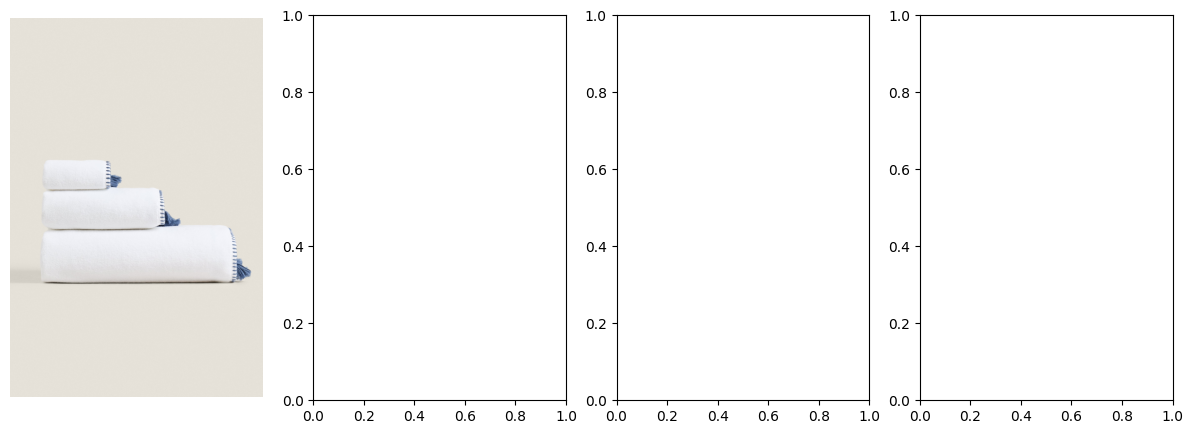

[1.21060151e-09 5.11717840e-02 1.48808839e-01 ... 5.79887844e-01
 5.83348356e-01 5.93146631e-01]


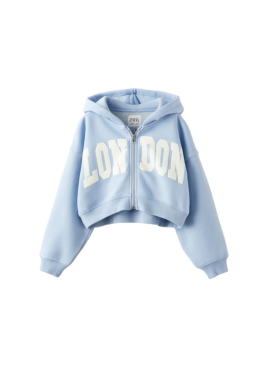

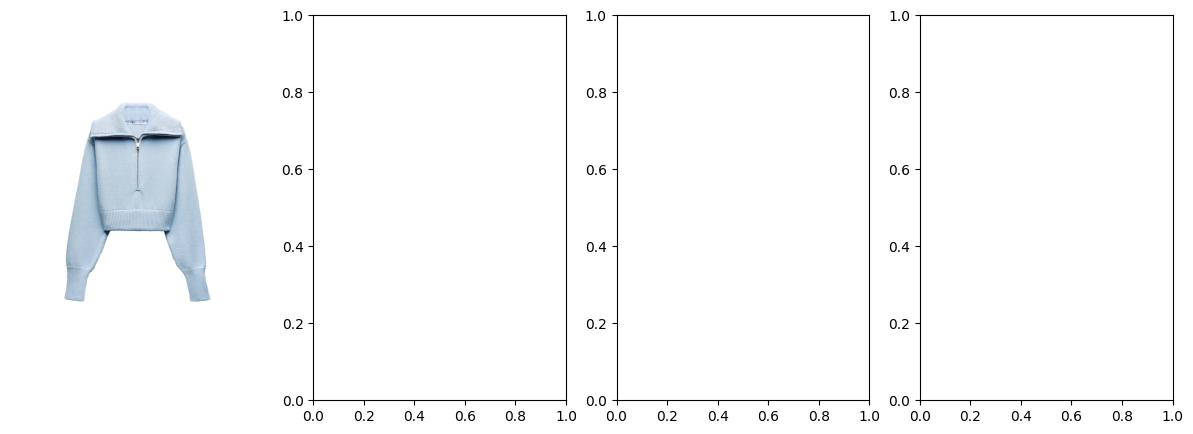

[0.         0.00577899 0.00577899 ... 0.5954493  0.60274637 0.69179509]


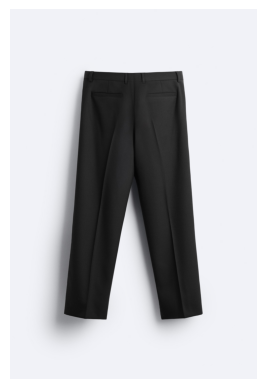

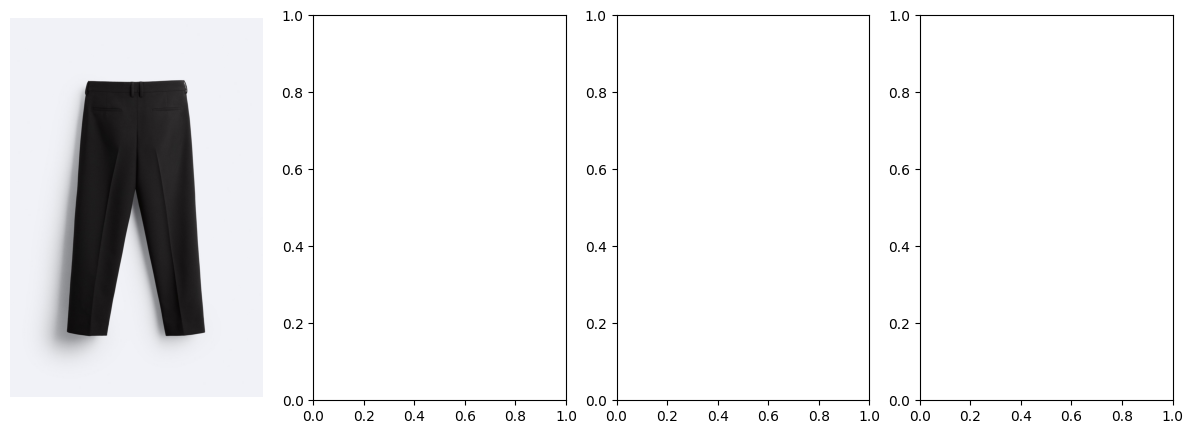

[1.23082301e-08 2.22416705e-02 2.25373587e-02 ... 5.97406803e-01
 6.05374882e-01 6.77192343e-01]


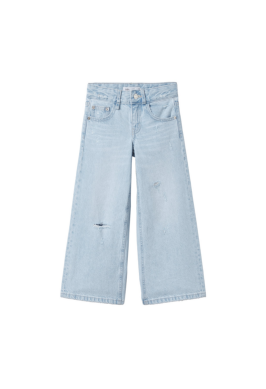

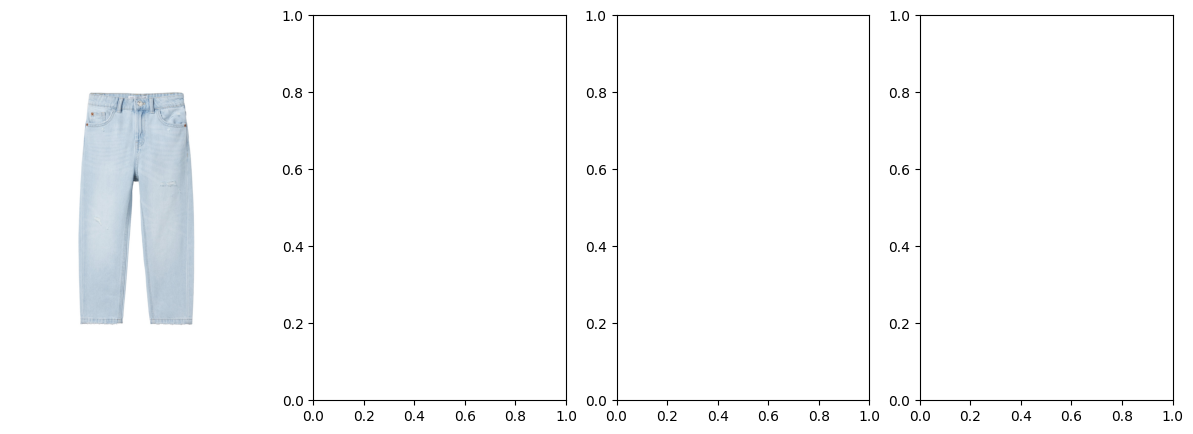

[0.         0.09078164 0.09608345 ... 0.62605158 0.63308958 0.6660678 ]


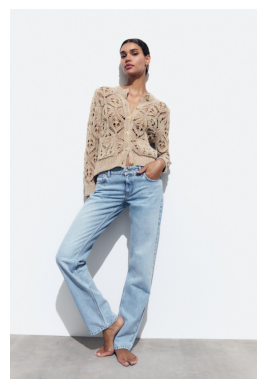

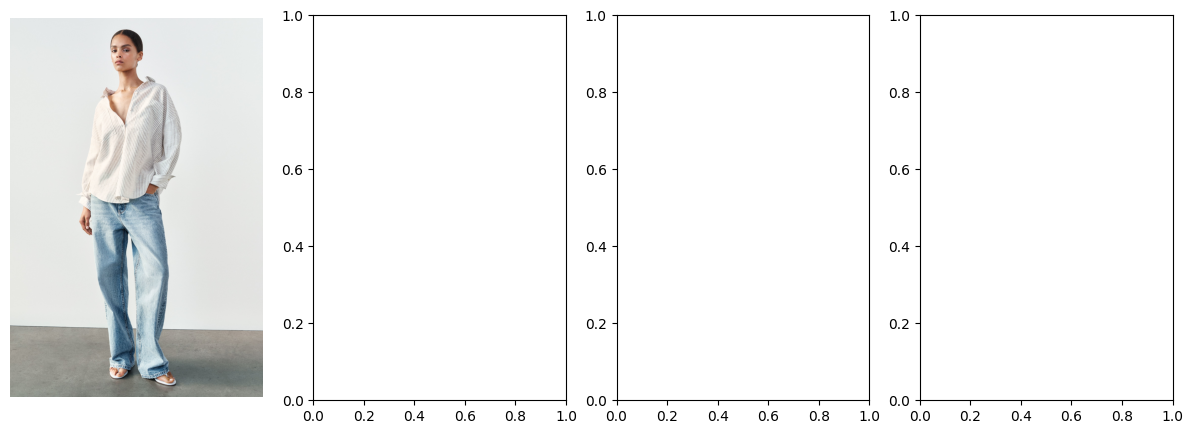

[6.86897650e-10 3.62875998e-02 1.21315757e-01 ... 6.51125000e-01
 6.56315451e-01 6.64501875e-01]


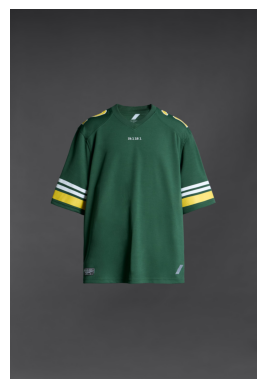

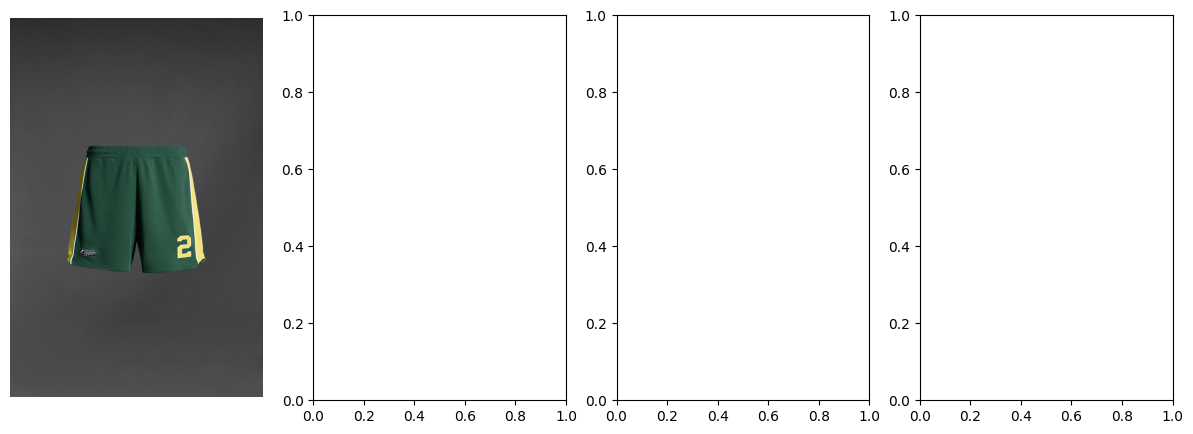

[1.28537707e-08 4.37721922e-02 4.49243498e-02 ... 6.06867707e-01
 6.07514526e-01 6.83374014e-01]


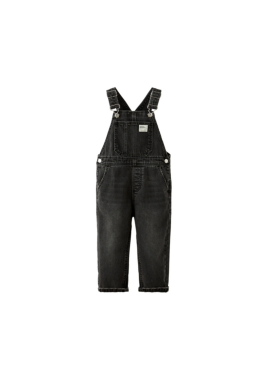

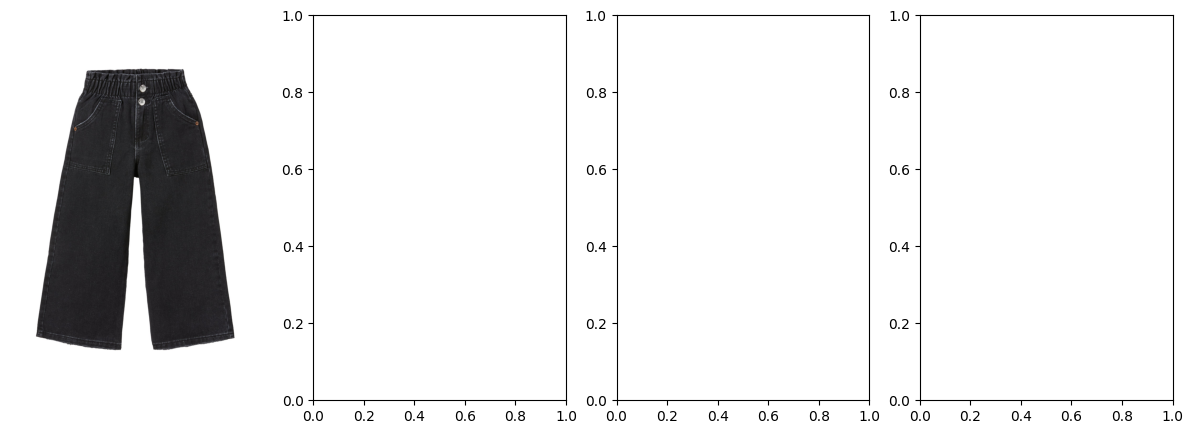

[0.         0.03724284 0.08274654 ... 0.59521036 0.59521036 0.6715182 ]


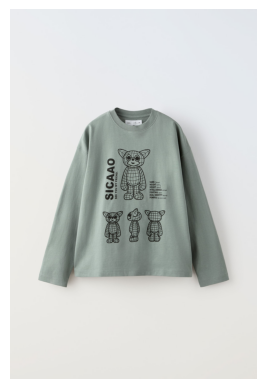

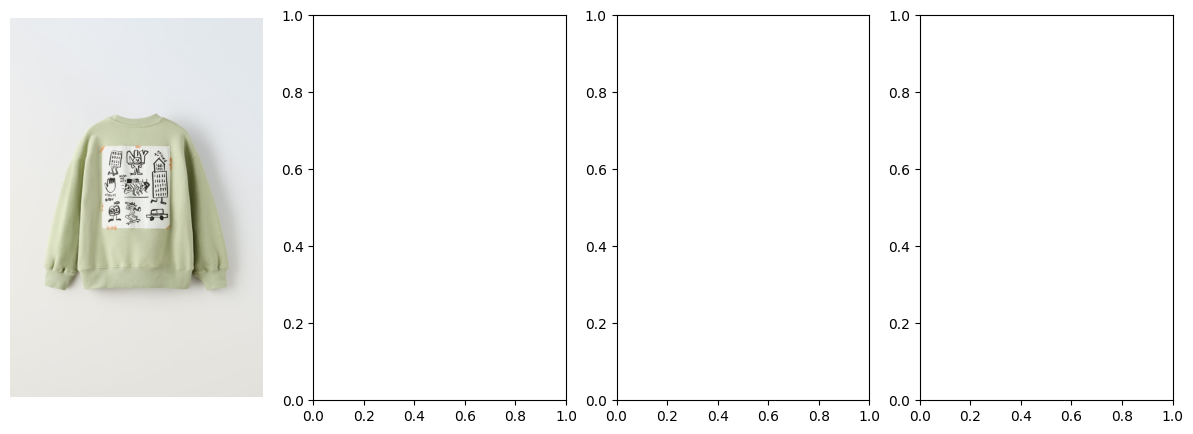

[5.64327618e-09 3.92851118e-02 4.28193799e-02 ... 6.18440542e-01
 6.24266816e-01 7.19317596e-01]


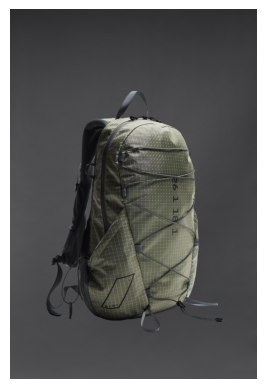

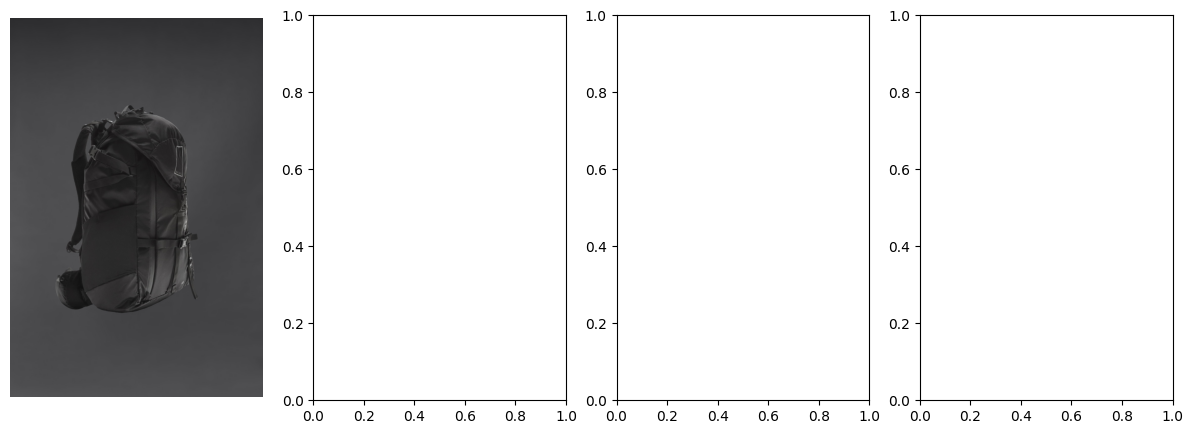

[0.         0.04170489 0.04171487 ... 0.585548   0.58860525 0.67864317]


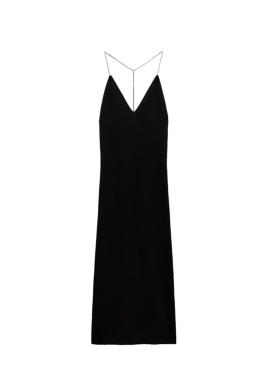

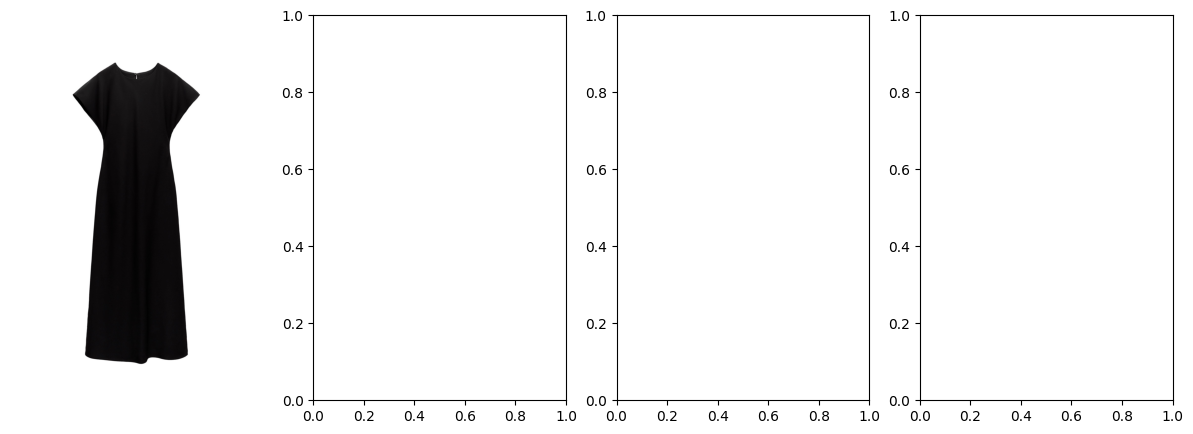

In [70]:
random_sample = images['path'].sample(n=10)
products = images['path']


for product in random_sample:
    show_product_neighbours(product)

In [64]:
def find_similar_products(new_embedding, num_options=3):
        
        k = 3 * num_options + 1
    
        similarities = np.array([cosine(new_embedding, emb) for emb in train_embeddings])
        
        k_lowest_values_indices = np.argsort(similarities)[:k]
    
        prev_row = -1
        nearest_images = []
        
        for idx in k_lowest_values_indices:
            if images.loc[idx, 'row'] == prev_row:
                continue
    
            nearest_images.append(images.loc[idx, 'path'])
            prev_row = images.loc[idx, 'row']
    
        return nearest_images[:num_options]

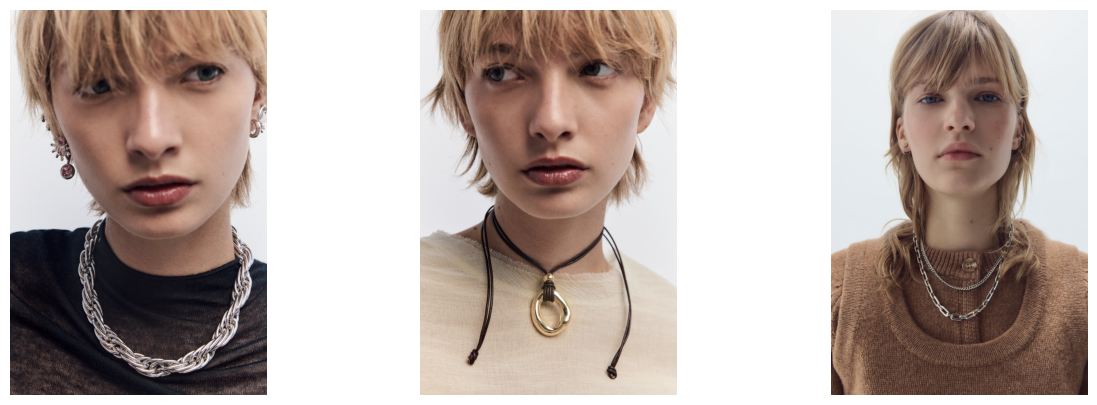

In [65]:
new_embedding = train_embeddings[0]

product_paths = find_similar_products(new_embedding, 3)

fig, axes = plt.subplots(1, len(product_paths), figsize=(15, 5))

for i, path in enumerate(product_paths):
    axes[i].imshow(get_image(path))
    axes[i].axis('off')

plt.show()